In [14]:
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection, LineCollection

In [21]:
def build_hex_mirror_graph(row_sizes):
    """
    Buduje graf sąsiedztwa dla luster w układzie heksagonalnym.
    row_sizes: lista z liczbą luster w kolejnych rzędach,
               np. [14, 16, 18, 20, 22, 24, 26, 28, 26, 24, 22, 20, 18, 16, 14]
    """
    mirrors = {}  # (row, col) -> mirror_id
    positions = {}  # mirror_id -> (x, y) fizyczna pozycja
    mirror_id = 0

    max_width = max(row_sizes)

    for row_idx, n_mirrors in enumerate(row_sizes):
        # Offset - centrowanie każdego rzędu
        offset = (max_width - n_mirrors) / 2.0
        for col_idx in range(n_mirrors):
            mirrors[(row_idx, col_idx)] = mirror_id

            # Pozycja fizyczna (uwzględniając hex staggering)
            x = offset + col_idx
            y = row_idx * np.sqrt(3) / 2  # odstęp hex między rzędami
            positions[mirror_id] = (x, y)
            mirror_id += 1

    total_mirrors = mirror_id
    adjacency = defaultdict(list)

    for row_idx, n_mirrors in enumerate(row_sizes):
        for col_idx in range(n_mirrors):
            mid = mirrors[(row_idx, col_idx)]

            # Sąsiedzi w tym samym rzędzie
            if col_idx > 0:
                adjacency[mid].append(mirrors[(row_idx, col_idx - 1)])
            if col_idx < n_mirrors - 1:
                adjacency[mid].append(mirrors[(row_idx, col_idx + 1)])

            # Sąsiedzi w rzędzie powyżej i poniżej
            for d_row, neighbor_row_idx in [(-1, row_idx - 1), (1, row_idx + 1)]:
                if 0 <= neighbor_row_idx < len(row_sizes):
                    n_neighbor = row_sizes[neighbor_row_idx]
                    delta = (n_neighbor - n_mirrors)

                    # W siatce hex, sąsiedztwo zależy od tego,
                    # czy sąsiedni rząd jest szerszy czy węższy
                    if delta > 0:  # sąsiedni rząd szerszy
                        neighbor_cols = [col_idx, col_idx + 1]
                    elif delta < 0:  # sąsiedni rząd węższy
                        neighbor_cols = [col_idx - 1, col_idx]
                    else:  # ten sam rozmiar
                        neighbor_cols = [col_idx - 1, col_idx, col_idx + 1]

                    for nc in neighbor_cols:
                        if 0 <= nc < n_neighbor:
                            nid = mirrors[(neighbor_row_idx, nc)]
                            if nid not in adjacency[mid]:
                                adjacency[mid].append(nid)

    return adjacency, positions, total_mirrors



def make_square_patch(center, size):
    """Kwadratowe lustro wycentrowane na (center)."""
    return patches.Rectangle(
        (center[0] - size / 2, center[1] - size / 2), size, size
    )

In [4]:
row_dict = {
    "row 1":9,
    "row 2":11,
    "row 3":13,
    "row 4":15,
    "row 5":17,
    "row 6":17,
    "row 7":17,
    "row 8":17,
    "row 9":17,
    "row 10":17,
    "row 11":17,
    "row 12":17,
    "row 13":17,
    "row 14":15,
    "row 15":13,
    "row 16":11,
    "row 17":9,
}

In [23]:
list(row_dict.values())
# Definicja rzędów (symetryczny sześciokąt)
row_sizes = list(row_dict.values())
adj, pos, n_total = build_hex_mirror_graph(row_sizes)
sq_size = 0.85

print(f"Łącznie luster: {n_total}")
print(f"Lustro 50 -> sąsiedzi: {adj[1]}")

Łącznie luster: 249
Lustro 50 -> sąsiedzi: [0, 2, 10, 11]


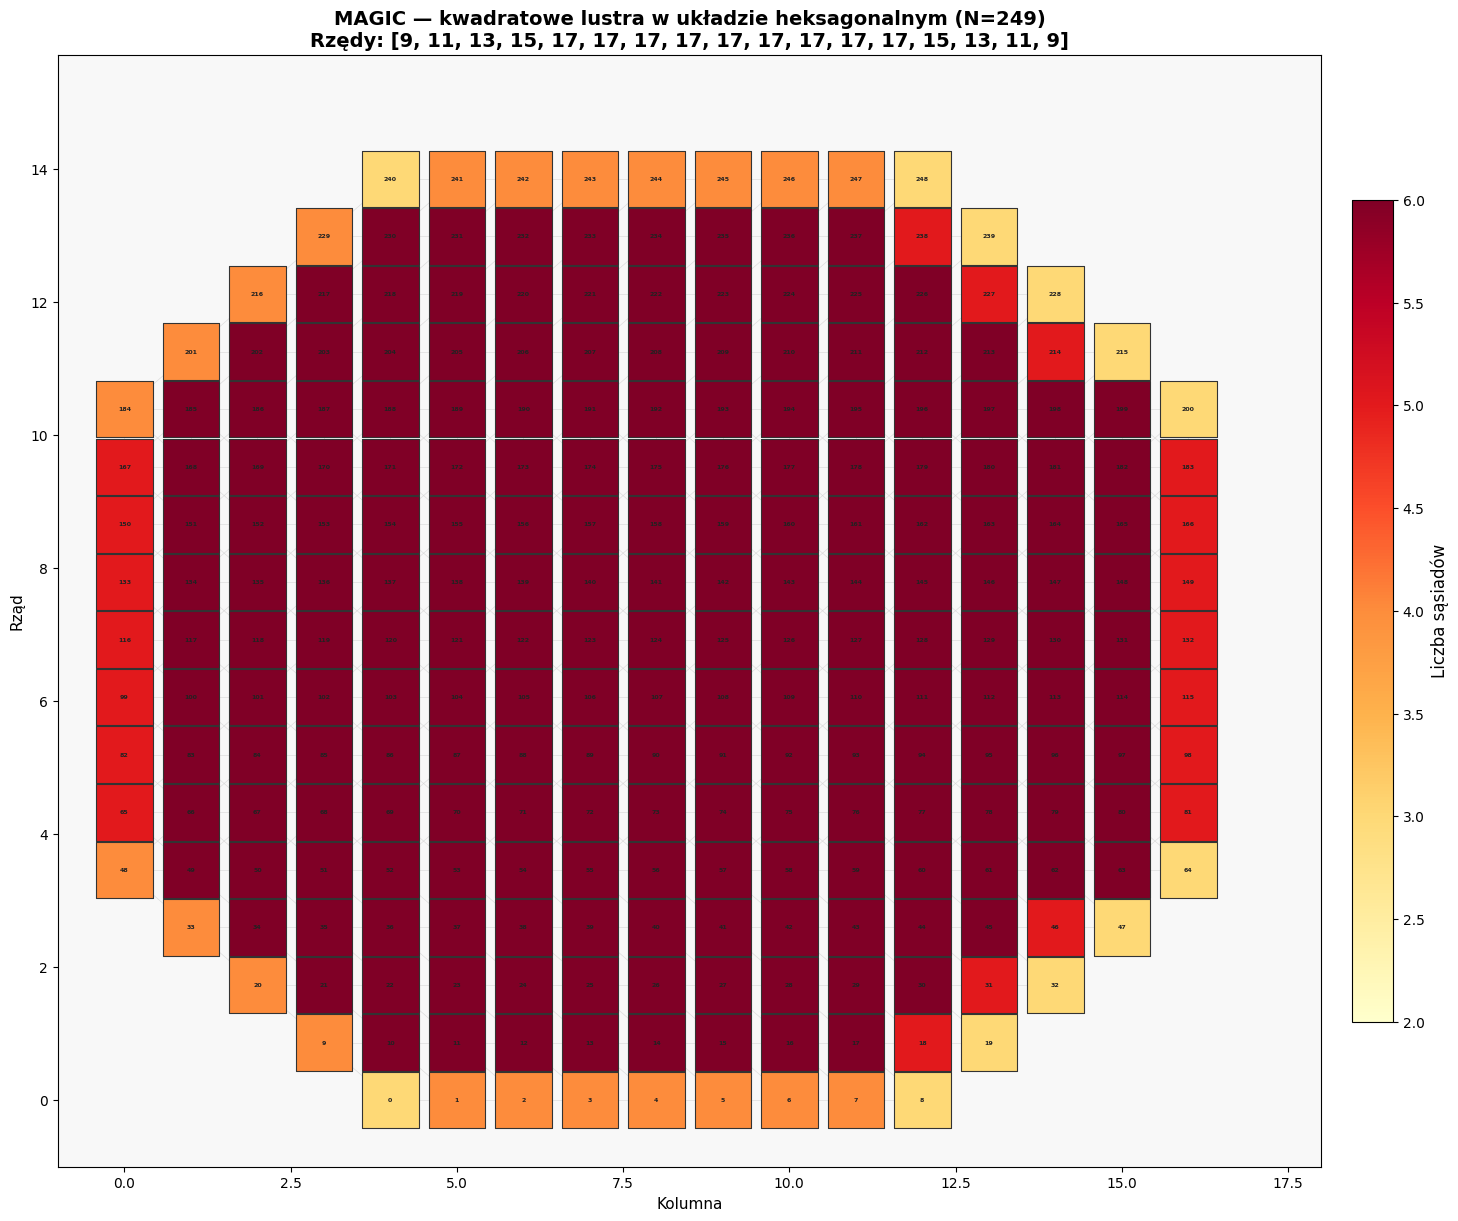

In [24]:
# ──────────────────────────────────────────────
# Wizualizacja 1: Graf sąsiedztwa + kwadraty
# ──────────────────────────────────────────────
fig, ax = plt.subplots(1, 1, figsize=(16, 14))

edge_lines = []
drawn_edges = set()
for mid, neighbors in adj.items():
    for nid in neighbors:
        edge_key = tuple(sorted((mid, nid)))
        if edge_key not in drawn_edges:
            drawn_edges.add(edge_key)
            edge_lines.append([pos[mid], pos[nid]])

lc = LineCollection(edge_lines, colors='#cccccc', linewidths=0.5,
                    zorder=1, alpha=0.6)
ax.add_collection(lc)

sq_patches = [make_square_patch(pos[mid], sq_size) for mid in range(n_total)]
n_neighbors = [len(adj[mid]) for mid in range(n_total)]

pc = PatchCollection(sq_patches, cmap='YlOrRd', edgecolors='#333333',
                     linewidths=0.8, zorder=2)
pc.set_array(np.array(n_neighbors))
pc.set_clim(2, 6)
ax.add_collection(pc)

for mid in range(n_total):
    x, y = pos[mid]
    ax.text(x, y, str(mid), ha='center', va='center',
            fontsize=4.5, fontweight='bold', color='#222222', zorder=3)

cbar = plt.colorbar(pc, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label('Liczba sąsiadów', fontsize=12)

ax.set_xlim(-1, max(row_sizes) + 1)
ax.set_ylim(-1, len(row_sizes) * np.sqrt(3) / 2 + 1)
ax.set_aspect('equal')
ax.set_title(f'MAGIC — kwadratowe lustra w układzie heksagonalnym (N={n_total})\n'
             f'Rzędy: {row_sizes}', fontsize=14, fontweight='bold')
ax.set_xlabel('Kolumna', fontsize=11)
ax.set_ylabel('Rząd', fontsize=11)
ax.grid(False)
ax.set_facecolor('#f8f8f8')
plt.tight_layout()

plt.show()

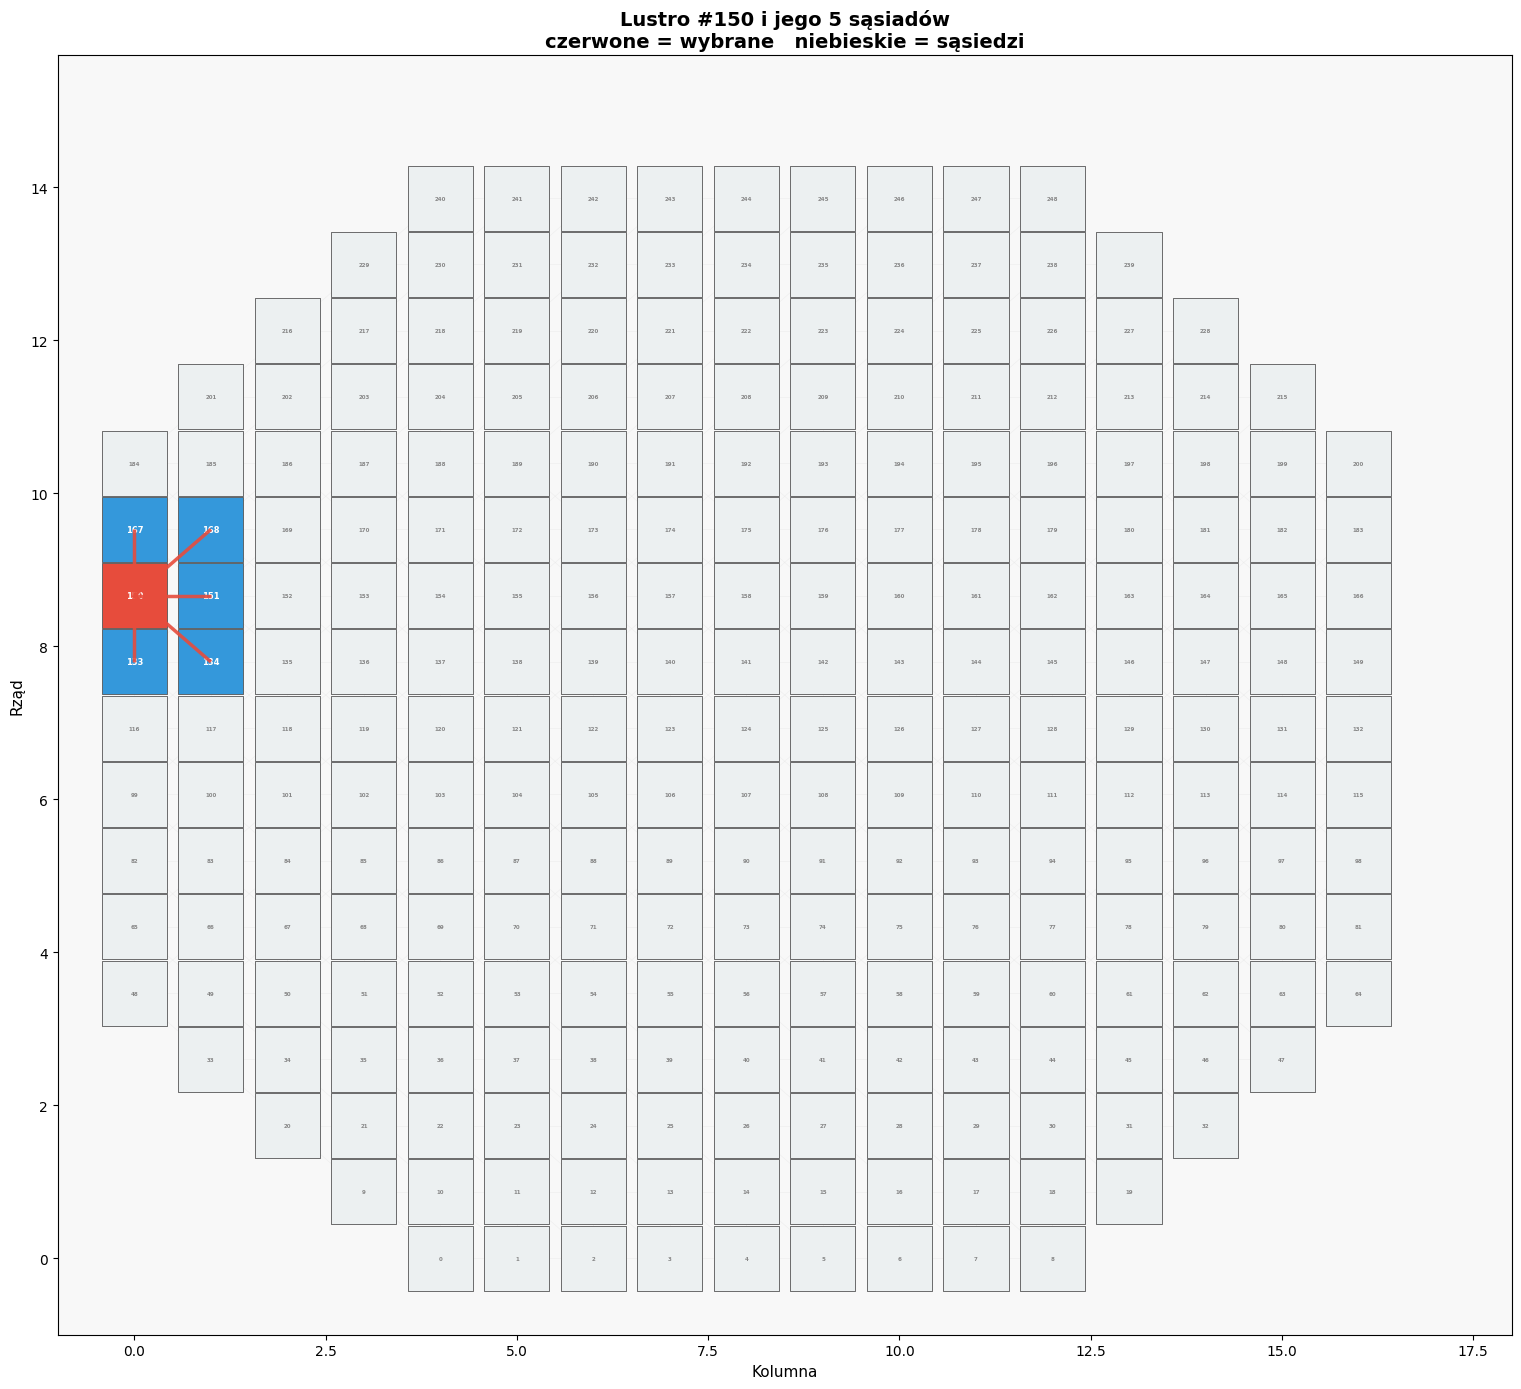

In [25]:
# ──────────────────────────────────────────────
# Wizualizacja 2: Podświetlenie wybranego lustra
# ──────────────────────────────────────────────
highlight_id = 150

fig, ax = plt.subplots(1, 1, figsize=(16, 14))

lc = LineCollection(edge_lines, colors='#dddddd', linewidths=0.4,
                    zorder=1, alpha=0.4)
ax.add_collection(lc)

highlight_edges = []
for nid in adj[highlight_id]:
    highlight_edges.append([pos[highlight_id], pos[nid]])

lc_hl = LineCollection(highlight_edges, colors='#e74c3c', linewidths=2.5,
                       zorder=4, alpha=0.9)
ax.add_collection(lc_hl)

neighbor_set = set(adj[highlight_id])
colors = []
for mid in range(n_total):
    if mid == highlight_id:
        colors.append('#e74c3c')
    elif mid in neighbor_set:
        colors.append('#3498db')
    else:
        colors.append('#ecf0f1')

sq_patches2 = [make_square_patch(pos[mid], sq_size) for mid in range(n_total)]
pc2 = PatchCollection(sq_patches2, facecolors=colors, edgecolors='#555555',
                      linewidths=0.6, zorder=2)
ax.add_collection(pc2)

for mid in range(n_total):
    x, y = pos[mid]
    fontcolor = 'white' if mid == highlight_id or mid in neighbor_set else '#888888'
    fs = 6 if mid == highlight_id or mid in neighbor_set else 4
    ax.text(x, y, str(mid), ha='center', va='center',
            fontsize=fs, fontweight='bold', color=fontcolor, zorder=3)

ax.set_xlim(-1, max(row_sizes) + 1)
ax.set_ylim(-1, len(row_sizes) * np.sqrt(3) / 2 + 1)
ax.set_aspect('equal')
ax.set_title(f'Lustro #{highlight_id} i jego {len(adj[highlight_id])} sąsiadów\n'
             'czerwone = wybrane   niebieskie = sąsiedzi',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Kolumna', fontsize=11)
ax.set_ylabel('Rząd', fontsize=11)
ax.grid(False)
ax.set_facecolor('#f8f8f8')
plt.tight_layout()
plt.show()